# Development of a denosumab biosimilar measure

Background
----------

We're building a new OpenPrescribing measure to track the uptake of denosumab biosimilars. Biosimilars for both denosumab 60mg (Prolia) and 120mg (Xgeva) became available recently, so this measure will help identify where branded products are still being prescribed when biosimilars could be used instead.

The measure will show "Proportion of denosumab prescribed as branded (Prolia or Xgeva)", so lower is better!

ERD diagram below:

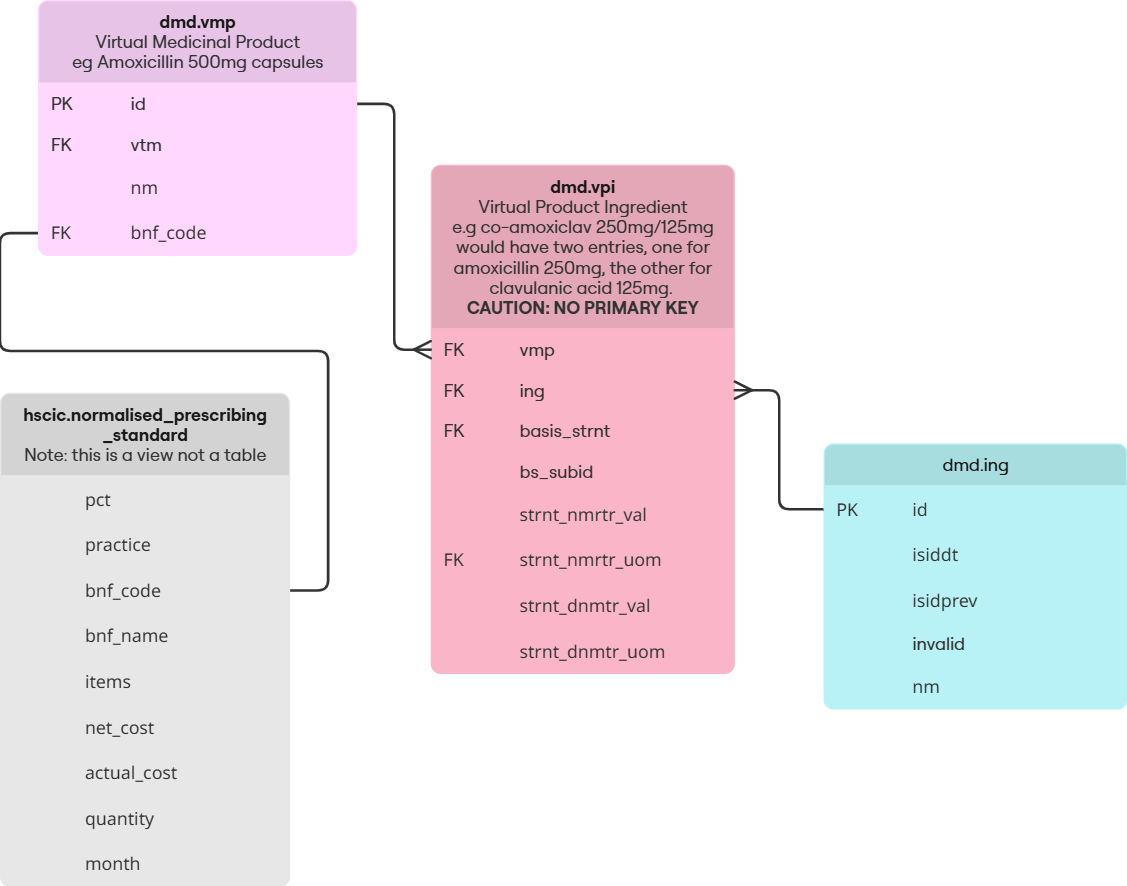



Setting Up Our Tools
--------------------


In [1]:
# Import the libraries we need:
from ebmdatalab import bq                  # Connects us to the prescribing database
import pandas as pd                        # Our main tool for handling data tables
import matplotlib.pyplot as plt            # Creates charts and graphs
import numpy as np                         # Helps with numerical calculations
import os                                  # Manages file paths
from datetime import datetime              # For date handling
import seaborn as sns                      # For enhanced visualisations

# This setting ensures we can see full product names in our results
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

# Create data directory if it doesn't exist
os.makedirs('../ONS_data', exist_ok=True)

Step 1: Find the correct ingredient code
----------------------------------------

First thing - we need is the right SNOMED CT ingredient code for denosumab. We check this using the [NHS dm+d ingredient browser](https://dmd-browser.nhsbsa.nhs.uk/ingredient/view/4182?ref=bmFtZT1kZW5vc3VtYWImc2hvd0ludmFsaWRJdGVtcz1mYWxzZQ%3D%3D). We identify the code as 446321003 .

Step 2: Check what's in the denominator
---------------------------------------

We now check to see what products are actually being prescribed and how they're coded. This helps us understand the BNF code structure and check our measure logic will capture everything correctly:

In [4]:
sql_denusomab_prescribing = """
SELECT 
  p.bnf_code,
  p.bnf_name,
  vmp.nm AS vmp_name,
  SUBSTR(p.bnf_code, 10, 2) AS brand_identifier,
  SUM(p.items) AS total_items,

FROM hscic.normalised_prescribing p
INNER JOIN dmd.vmp vmp ON CONCAT(SUBSTR(p.bnf_code,0,9),'AA', SUBSTR(p.bnf_code,-2), SUBSTR(p.bnf_code,-2)) = vmp.bnf_code
INNER JOIN dmd.vpi AS vpi ON vmp.id = vpi.vmp
WHERE vpi.ing = 446321003  -- Denosumab
  AND p.month >= '2025-01-01'
GROUP BY p.bnf_code, p.bnf_name, vmp.nm, SUBSTR(p.bnf_code, 10, 2)
ORDER BY total_items DESC
"""

# Execute query and cache results
df_denosumab_prescribing = bq.cached_read(
    sql_denusomab_prescribing,
    csv_path=os.path.join('..', 'denusomab_biosimilar data', 'ONS_denusomab_detailed.csv')
)

Downloading: 100%|█████████████████████████████████████████████████████████████|


This query will process 197.39 GB when run..

In [5]:
print(f"Data shape: {df_denosumab_prescribing.shape}")
print(f"Number of unique drugs: {df_denosumab_prescribing['bnf_name'].nunique()}")
# Display sample of the data
display(df_denosumab_prescribing.head(10))

Data shape: (6, 6)
Number of unique drugs: 6


,bnf_code,bnf_name,vmp_name,brand_identifier,total_items,total_cost
0,0606020Z0AAAAAA,Denosumab 60mg/1ml inj pre-filled syringes,Denosumab 60mg/1ml solution for injection pre-filled syringes,AA,49906,8.933867e+06
1,0606020Z0BBAAAA,Prolia 60mg/1ml solution for injection pre-filled syringes,Denosumab 60mg/1ml solution for injection pre-filled syringes,BB,32974,5.900961e+06
2,0606020Z0BCAAAB,Xgeva 120mg/1.7ml solution for injection vials,Denosumab 120mg/1.7ml solution for injection vials,BC,1521,4.771763e+05
3,0606020Z0AAABAB,Denosumab 120mg/1.7ml solution for injection vials,Denosumab 120mg/1.7ml solution for injection vials,AA,838,2.589404e+05
4,0606020Z0BCABAC,Xgeva 120mg/1ml solution for injection pre-filled syringes,Denosumab 120mg/1ml solution for injection pre-filled syringes,BC,476,1.485796e+05
5,0606020Z0AAACAC,Denosumab 120mg/1ml inj pre-filled syringes,Denosumab 120mg/1ml solution for injection pre-filled syringes,AA,331,1.061351e+05


Step 3: Understanding the BNF code structure
--------------------------------------------

Looking at the results, we can see the pattern:

-   **`AA`** = Generic/biosimilar (positions 10-11 of BNF code)
-   **`BB`** = Prolia (branded 60mg)
-   **`BC`** = Xgeva (branded 120mg)

So for our numerator logic, we should be able to use `SUBSTR(p.bnf_code,10,2) != 'AA'` to correctly capture all branded products (Prolia and Xgeva) while excluding biosimilars. 

**CAUTION:** It may be worth confirming that this works as expected once more up to date prescribing data is available (denosumab biosimilar prescribing is likely to begin to appear with November/ December data. Latest available data is September 2025.



Step 4: Final measure definition
--------------------------------

Based on the above, here's the proposed measure JSON: